# Dependencies

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import gc
import time 
import shutil
from sklearn.model_selection import train_test_split
from kaggle_datasets import KaggleDatasets

import tensorflow as tf

from tensorflow.python.client import device_lib
from tensorflow.keras import Model, layers, Input, Sequential
from sklearn.metrics import log_loss

from joblib import Parallel, delayed
import cv2

2023-01-25 11:18:06.366874: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2023-01-25 11:18:06.366993: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Setting up Strategy

In [ ]:
def set_tpu():
    try: 
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect() 
        tf.keras.mixed_precision.set_global_policy("mixed_bfloat16")
        tf.config.set_soft_device_placement(True)
        strategy = tf.distribute.experimental.TPUStrategy(tpu)
        physical_devices = tf.config.list_logical_devices('TPU')
        return strategy, physical_devices
    except:
        False
        
def set_cpu_gpus():
    try: 
        # printed out the detected devices
        list_ld = device_lib.list_local_devices()
        for dev in list_ld:
            print(dev.name,dev.memory_limit)
        
        physical_devices = tf.config.list_physical_devices(
            'GPU' if len(list_ld) - 1 else 'CPU'
        )
        tf.config.optimizer.set_jit(True)
        tf.keras.mixed_precision.set_global_policy("mixed_float16")
        
        # For GPU devices, set growth memory constraint
        if 'GPU' in physical_devices[-1]:
            for pd in physical_devices:
                tf.config.experimental.set_memory_growth(pd, True)
                pass
        
        strategy = tf.distribute.MirroredStrategy()
        return strategy, physical_devices
    except: 
        print('No Device Detected!')
        
strategy, physical_devices = set_tpu() or set_cpu_gpus()
tf.get_logger().setLevel('ERROR')
physical_devices, tf.__version__

# Importing Data & EDA

In [2]:
TRAIN_PATH = '/kaggle/input/rsna-breast-cancer-detection-poi-images/bc_1024_roi_train/bc_1024_roi_train'

In [41]:
df = pd.read_csv('/kaggle/input/rsna-breast-cancer-detection/train.csv')

In [42]:
df['img_path'] = df.apply(
    lambda i: os.path.join(
        f"{TRAIN_PATH}", str(i['patient_id']) + "_" + str(i['image_id']) + '.png'
    ), axis=1
)

In [43]:
DEBUG = False

In [44]:
# df = pd.read_csv("/kaggle/input/rsna-breast-cancer-detection/train.csv")
test_df = pd.read_csv("/kaggle/input/rsna-breast-cancer-detection/test.csv")
sub_df = pd.read_csv('/kaggle/input/rsna-breast-cancer-detection/sample_submission.csv')
sub_df.to_csv('submission.csv',index=False)
y = df["cancer"]

if DEBUG:
    y = y.sample(frac= 0.1)
    df= df.iloc[y.index]

In [45]:
df.age = df.age.fillna(df.age.median())
df.density = df.density.fillna(df.density.mode())
df.density = df.density.fillna('E')

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54706 entries, 0 to 54705
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   site_id                  54706 non-null  int64  
 1   patient_id               54706 non-null  int64  
 2   image_id                 54706 non-null  int64  
 3   laterality               54706 non-null  object 
 4   view                     54706 non-null  object 
 5   age                      54706 non-null  float64
 6   cancer                   54706 non-null  int64  
 7   biopsy                   54706 non-null  int64  
 8   invasive                 54706 non-null  int64  
 9   BIRADS                   26286 non-null  float64
 10  implant                  54706 non-null  int64  
 11  density                  54706 non-null  object 
 12  machine_id               54706 non-null  int64  
 13  difficult_negative_case  54706 non-null  bool   
 14  img_path              

In [47]:
train_files = glob.glob ('/kaggle/input/rsna-breast-cancer-detection-poi-images/bc_768_roi/bc_768_roi/train/'+"*.png")
test_files = glob.glob ('/kaggle/input/rsna-breast-cancer-detection-poi-images/bc_768_roi/bc_768_roi/test/'+"*.png")

In [48]:
Train_In_Path ="/kaggle/input/rsna-breast-cancer-detection-poi-images/bc_768_roi/bc_768_roi/train/"
Test_In_Path = "/kaggle/input/rsna-breast-cancer-detection-poi-images/bc_768_roi/bc_768_roi/test/"

In [49]:
strategy

In [50]:
#Get your credentials
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
user_credential = user_secrets.get_gcloud_credential()

#Set the credentials
user_secrets.set_tensorflow_credential(user_credential)

In [51]:
# if 'TPU' in str(strategy):
#     TPU requires the data to be in a GDS bucket we therefore use the GDS path links 
#     Train_In_Path = KaggleDatasets().get_gcs_path('rsna-breast-cancer-detection-poi-images')
#     Train_In_Path = Train_In_Path+ '/bc_768_roi/bc_768_roi/train/'

#     Test_In_Path = KaggleDatasets().get_gcs_path('rsna-breast-cancer-detection-poi-images')
#     Test_In_Path = Test_In_Path+'/bc_768_roi/bc_768_roi/test/'
# else:
#     Train_In_Path ="/kaggle/input/rsna-breast-cancer-detection-poi-images/bc_768_roi/bc_768_roi/train/"
#     Test_In_Path = "/kaggle/input/rsna-breast-cancer-detection-poi-images/bc_768_roi/bc_768_roi/test/"

In [52]:
Train_In_Path = KaggleDatasets().get_gcs_path('rsna-breast-cancer-detection-poi-images')
Train_In_Path = Train_In_Path+ '/bc_768_roi/bc_768_roi/train/'

Test_In_Path = KaggleDatasets().get_gcs_path('rsna-breast-cancer-detection-poi-images')
Test_In_Path = Test_In_Path+'/bc_768_roi/bc_768_roi/test/'

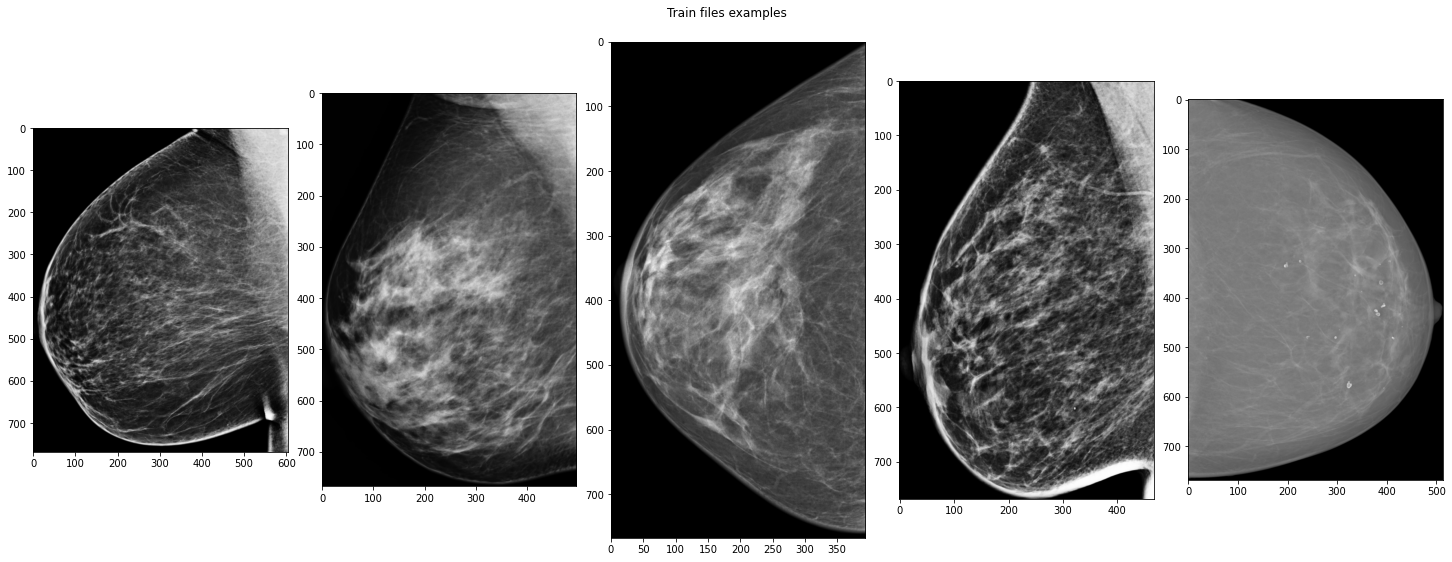

In [53]:
fig,ax = plt.subplots(1,5,figsize = (20,8))
ax= np.ravel(ax)

for i in range(5):
    img = cv2.imread(train_files[i])
    ax[i].imshow(img)
    
fig.suptitle("Train files examples")
plt.tight_layout(pad = 0) 
plt.show()

In [54]:
df['img_path'] = Train_In_Path + df['patient_id'].astype(str) + '_' + df['image_id'].astype(str) + '.png'

In [55]:
test_df = pd.read_csv("/kaggle/input/rsna-breast-cancer-detection/test.csv")

In [56]:
test_df["img_path"] = Test_In_Path+test_df["patient_id"].astype(str) +"_"+ test_df ["image_id"].astype(str)+".png"

# Train, Test Split

In [57]:
X = df["img_path"]
y = df["cancer"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1234)

In [58]:
if 'TPU' in str(strategy):
        Rescaling = tf.keras.layers.experimental.preprocessing.Rescaling(1./255,name = "Rescaling0_1")
        RandomFlip = tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal')
        RandomRotation = tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)
else:
    Rescaling = layers.experimental.preprocessing.Rescaling(1./255,name = "Rescaling0_1")
    RandomFlip = layers.experimental.preprocessing.RandomFlip('horizontal')
    RandomRotation = layers.experimental.preprocessing.RandomRotation(0.2) 
    
data_augmentation  = Sequential([
    #layers.InputLayer(input_shape=(RESIZE,RESIZE,3)), 
    RandomFlip,
    RandomRotation])

In [59]:
def set_tpu():
    try: 
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect() 
        tf.keras.mixed_precision.set_global_policy("mixed_bfloat16")
        tf.config.set_soft_device_placement(True)
        strategy = tf.distribute.experimental.TPUStrategy(tpu)
        physical_devices = tf.config.list_logical_devices('TPU')
        return strategy, physical_devices
    except:
        False
        
def set_cpu_gpus():
    try: 
        # printed out the detected devices
        list_ld = device_lib.list_local_devices()
        for dev in list_ld:
            print(dev.name,dev.memory_limit)
        
        physical_devices = tf.config.list_physical_devices(
            'GPU' if len(list_ld) - 1 else 'CPU'
        )
        tf.config.optimizer.set_jit(True)
        tf.keras.mixed_precision.set_global_policy("mixed_float16")
               # For GPU devices, set growth memory constraint
        if 'GPU' in physical_devices[-1]:
            for pd in physical_devices:
                tf.config.experimental.set_memory_growth(pd, True)
                pass
        
        strategy = tf.distribute.MirroredStrategy()
        return strategy, physical_devices
    except: 
        print('No Device Detected!')
        
strategy, physical_devices = set_tpu() or set_cpu_gpus()
tf.get_logger().setLevel('ERROR')
physical_devices, tf.__version__

2023-01-25 11:21:47.133330: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2023-01-25 11:21:47.133752: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30020}
2023-01-25 11:21:47.135771: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2023-01-25 11:21:47.135822: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30020}


([LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU'),
  LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'),
  LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'),
  LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'),
  LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'),
  LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'),
  LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'),
  LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU')],
 '2.4.1')

# Pipeline

In [60]:
AUTOTUNE = tf.data.AUTOTUNE # allows for parallel loading 

DEBUG = False
RESIZE = 128
EPOCHS = 10
#BATCH_SIZE = 32
BATCH_SIZE = 16 * strategy.num_replicas_in_sync

In [61]:
#decode file back to image (note the 3 channels for colored images)
def decode_read(file_path,label=None):
    file_bytes = tf.io.read_file(file_path) #reads the image file path as a string
    img = tf.image.decode_png(file_bytes, channels=3) #color images
    img = tf.image.convert_image_dtype(img, tf.float32) #convert unit8 tensor to floats in the [0,1]range
    img = tf.image.resize(img, [RESIZE, RESIZE]) 
    return img, label if label!=None else img

# save date in cache for faster loading, buffered prefetching will load images from disk without having I/O become blocking
def prepare(ds,shuffle_buffer_size=1000):
    ds = ds.cache()
    ds = ds.shuffle(8 * BATCH_SIZE, reshuffle_each_iteration = False)
#     ds = ds.repeat() #re-initialise dataset (i.e start from beginning of dataset not the end)
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

def augment_image(img,label):
    img = tf.image.random_flip_left_right(img)
#     img = tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)(img)
#     img = layers.experimental.preprocessing.Rescaling(1./255)(img)
    return img,label

In [62]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train.values,y_train.values))
val_ds = tf.data.Dataset.from_tensor_slices((X_test.values,y_test.values))
test_ds = tf.data.Dataset.from_tensor_slices((test_df["img_path"].values))

train_ds = train_ds.map(decode_read, num_parallel_calls=AUTOTUNE)
val_ds= val_ds.map(decode_read, num_parallel_calls=AUTOTUNE)
test_ds= test_ds.map(decode_read, num_parallel_calls=AUTOTUNE)

#train images only
train_ds= train_ds.map(augment_image, num_parallel_calls=AUTOTUNE)

# Cache, shuffle, batch 
train_ds = prepare(train_ds)
val_ds = prepare(val_ds)
test_ds = prepare(test_ds)

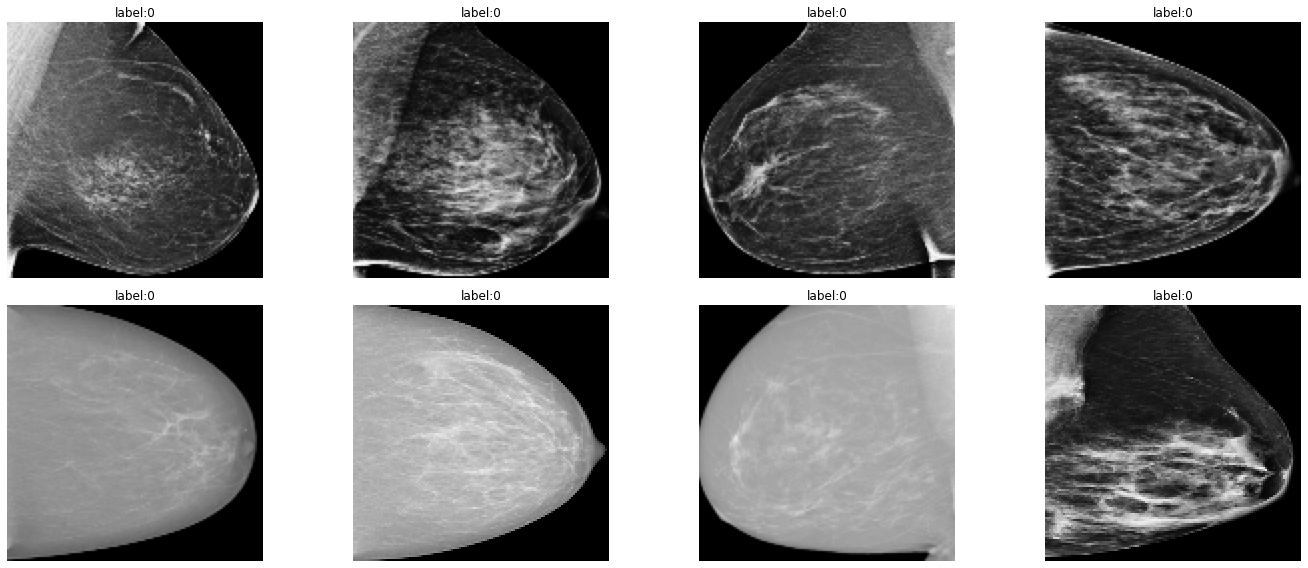

In [63]:
image_batch, label_batch = next(iter(train_ds))

fig, ax = plt.subplots(2,4,figsize=(20,8), sharey = True, sharex = True)
ax = np.ravel(ax)
for i in range(8):
    img = tf.image.convert_image_dtype(image_batch[i].numpy(), tf.float32) 
    ax[i].imshow(img)
    ax[i].set_title(f"label:{label_batch[i].numpy()}")
    ax[i].axis('off') 
                   
plt.tight_layout()
plt.show()  

# Model

In [64]:
tf.keras.backend.clear_session()

In [65]:
from tensorflow.keras import Model, layers, Input, Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D
from tensorflow.keras.applications.vgg16 import VGG16


In [66]:
if 'TPU' in str(strategy):
        Rescaling = tf.keras.layers.experimental.preprocessing.Rescaling(1./255,name = "Rescaling0_1")
        RandomFlip = tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal')
        RandomRotation = tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)
else:
    Rescaling = layers.Rescaling(1./255,name = "Rescaling0_1")
    RandomFlip = layers.RandomFlip('horizontal')
    RandomRotation = layers.RandomRotation(0.2) 
    
data_augmentation  = Sequential([
    #layers.InputLayer(input_shape=(RESIZE,RESIZE,3)), 
    RandomFlip,
    RandomRotation])

In [67]:
from tensorflow.keras.layers import MaxPool2D

In [69]:
with strategy.scope():
    model = Sequential()
    model.add(Conv2D(input_shape=(RESIZE,RESIZE,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
    model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(Flatten())
    model.add(Dense(units=4096,activation="relu"))
    model.add(Dense(units=4096,activation="relu"))
    model.add(Dense(units=1, activation="sigmoid"))
#     model.add(Conv2D(512, (3,3), 1, activation='relu', input_shape= (256,256,3)))
#     model.add(MaxPooling2D())

#     model.add(Conv2D(1024, (3,3), 1, activation='relu'))
#     model.add(MaxPooling2D())

#     model.add(Conv2D(512, (3,3), 1, activation='relu'))
#     model.add(MaxPooling2D())

#     model.add(Flatten())

#     model.add(Dense(256,activation='relu'))
#     model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer="adam",loss= tf.keras.losses.BinaryCrossentropy(),metrics = ['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 128, 128, 64)      1792      
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 128, 128, 64)      36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 64, 64, 128)       73856     
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 64, 64, 128)       147584    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 32, 32, 256)      

In [ ]:
#from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

#checkpoint = ModelCheckpoint("vgg16_1.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

#early = EarlyStopping(monitor='val_acc', min_delta=0, patience=20, verbose=1, mode='auto')

# hist = model.fit_generator(steps_per_epoch=50,generator=train_ds, validation_data= val_ds, validation_steps=5,epochs=EPOCHS)
history = model.fit(
  train_ds,
  steps_per_epoch=100, 
  validation_data=val_ds,
  validation_steps=10,
  epochs=EPOCHS
)

In [37]:
model.save(os.path.join('/kaggle/working/','semi_final_VGG16.h5'))

# Model Evaluation

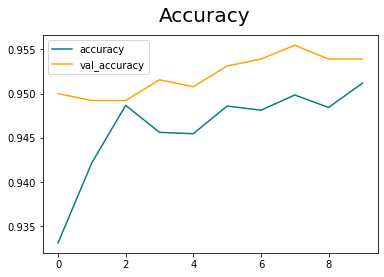

In [38]:
fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc='upper left')
plt.savefig('Accuracy')
plt.show()

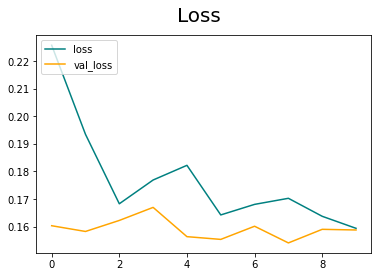

In [39]:
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc='upper left')
plt.savefig('Loss01')
plt.show()

In [29]:
from tensorflow.keras.models import load_model

In [ ]:
new_model = load_model('/kaggle/input/semifinal-vgg16-model/semi_final_VGG16.h5')

In [46]:
test_preds = model.predict(test_ds)
test_preds.reshape(-1)

array([[bfloat16(0.0327148438)],
       [bfloat16(0.0140991211)],
       [bfloat16(0.0197753906)],
       [bfloat16(0.04296875)]], dtype=bfloat16)

# Submission

In [ ]:
test_df = pd.read_csv("/kaggle/input/rsna-breast-cancer-detection/test.csv")
pred_df = pd.DataFrame({'prediction_id':test_df.prediction_id,
                        'cancer':test_preds.reshape(-1)})
del sub_df['cancer']

sub_df = sub_df.merge(pred_df, on='prediction_id', how='left')
sub_df = sub_df.groupby('prediction_id')['cancer'].mean().reset_index()  # merge duplicate prediction_id
sub_df.to_csv('submission.csv',index=False)
sub_df.head()